# Echopy: NASC - Nautical Area Scattering Coefficient - $m^2 nmi^{-2}$


In [1]:
import os
import subprocess
from typing import List, Optional, Union, Tuple

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.dates import date2num

import echopype as ep
import echopype.utils
from echopype.testing import TEST_DATA_FOLDER

-------

**Sv2NASC() echopy function [HERE](https://github.com/open-ocean-sounding/echopy/blob/master/echopy/utils/transform.py)**

In [2]:
def Sv2NASC(Sv, r, r0, r1, operation='mean'):
    """
    Compute Nautical Area Scattering Soefficient (m2 nmi-2), by integrating Sv
    in a given range interval.
    
    Parameters
    ----------
        Sv (float)    : 2D array with Sv data (dB m-1)
        r  (float)    : 1D array with range data (m)
        r0 (int/float): Top range limit (m)
        r1 (int/float): Bottom range limit (m)
        method (str)  : Method for calculating NASC. Accepts "mean" or "sum"
        
    Returns
    -------
        float: 1D array with Nautical Area Scattering Coefficient data.
        float: 1D array with the percentage of vertical samples integrated.
    """
   
    # get r0 and r1 indexes
    r0 = np.argmin(abs(r-r0))
    r1 = np.argmin(abs(r-r1))
    
    # get number and height of samples 
    ns     = len(r[r0:r1])
    sh = np.r_[np.diff(r), np.nan]
    sh = np.tile(sh.reshape(-1,1), (1,len(Sv[0])))[r0:r1,:]
    
    # compute NASC    
    sv = echopype.utils.mask_transformation.lin(Sv[r0:r1, :])
    if operation=='mean':    
        NASC = np.nanmean(sv * sh, axis=0) * ns * 4*np.pi*1852**2
    elif operation=='sum':
        NASC = np.nansum (sv * sh, axis=0)      * 4*np.pi*1852**2 
    else:
        raise Exception('Method not recognised')
    
    # compute percentage of valid values (not NAN) behind every NASC integration    
    per = (len(sv) - np.sum(np.isnan(sv*sh), axis=0)) / len(sv) * 100
    
    # correct NASC with the proportion of valid values
    NASC = NASC/(per/100)
        
    return NASC, per

---------

**Understanding echopy NASC - step by step**

In [3]:
# Creating a mock `data`
data = np.array([
        [1.0, 2.0, 3.0, 4.0, np.nan],
        [6.0, 7.0, 8.0, 9.0, 10.0],
        [11.0, 12.0, 13.0, 14.0, 15.0],
        [16.0, 17.0, 18.0, 19.0, np.nan],
        [21.0, 22.0, 23.0, 24.0, 25.0],
    ])

# example dimension (`echo-range`)
dim = np.array([0.5, 1.5, 2.5, 3.5, 9])

In [4]:
# Ensure that the `Sv` input for the Sv2NASC() function is in dB. 
# In our mock data, `Sv` is represented by the `data` variable.
data = echopype.utils.mask_transformation.log(data)

In [5]:
data

array([[ 0.        ,  3.01029996,  4.77121255,  6.02059991,         nan],
       [ 7.7815125 ,  8.4509804 ,  9.03089987,  9.54242509, 10.        ],
       [10.41392685, 10.79181246, 11.13943352, 11.46128036, 11.76091259],
       [12.04119983, 12.30448921, 12.55272505, 12.78753601,         nan],
       [13.22219295, 13.42422681, 13.61727836, 13.80211242, 13.97940009]])

In [6]:
r = dim
Sv = data
r0=2
r1=20

In [7]:
# get r0 and r1 indexes
r0 = np.argmin(abs(r-r0))
r1 = np.argmin(abs(r-r1))

In [8]:
sh = np.r_[np.diff(r), np.nan]

In [9]:
np.r_[np.diff(r)]

array([1. , 1. , 1. , 5.5])

In [10]:
np.r_[np.diff(r), np.nan]

array([1. , 1. , 1. , 5.5, nan])

In [11]:
sh.reshape(-1,1)

array([[1. ],
       [1. ],
       [1. ],
       [5.5],
       [nan]])

In [12]:
np.tile(sh.reshape(-1,1), (1,len(Sv[0])))

array([[1. , 1. , 1. , 1. , 1. ],
       [1. , 1. , 1. , 1. , 1. ],
       [1. , 1. , 1. , 1. , 1. ],
       [5.5, 5.5, 5.5, 5.5, 5.5],
       [nan, nan, nan, nan, nan]])

In [13]:
sh = np.tile(sh.reshape(-1,1), (1,len(Sv[0])))[r0:r1,:]

In [14]:
sh

array([[1. , 1. , 1. , 1. , 1. ],
       [1. , 1. , 1. , 1. , 1. ],
       [5.5, 5.5, 5.5, 5.5, 5.5]])

In [15]:
Sv

array([[ 0.        ,  3.01029996,  4.77121255,  6.02059991,         nan],
       [ 7.7815125 ,  8.4509804 ,  9.03089987,  9.54242509, 10.        ],
       [10.41392685, 10.79181246, 11.13943352, 11.46128036, 11.76091259],
       [12.04119983, 12.30448921, 12.55272505, 12.78753601,         nan],
       [13.22219295, 13.42422681, 13.61727836, 13.80211242, 13.97940009]])

In [16]:
sv = echopype.utils.mask_transformation.lin(Sv[r0:r1, :])
sv

array([[ 6.,  7.,  8.,  9., 10.],
       [11., 12., 13., 14., 15.],
       [16., 17., 18., 19., nan]])

In [17]:
NASC = np.nansum (sv * sh, axis=0) * 4 * np.pi * 1852**2
# NASC_test is just a simple sum to verify the output visually
NASC_test = np.nansum (sv * sh, axis=0)
display(NASC_test)
display(NASC)

array([105. , 112.5, 120. , 127.5,  25. ])

array([4.52565171e+09, 4.84891254e+09, 5.17217338e+09, 5.49543422e+09,
       1.07753612e+09])

--------

**Test Sv2NASC() using mock data**

In [18]:
# Creating a mock data
data = np.array([
        [1.0, 2.0, 3.0, 4.0, np.nan],
        [6.0, 7.0, 8.0, 9.0, 10.0],
        [11.0, 12.0, 13.0, 14.0, 15.0],
        [16.0, 17.0, 18.0, 19.0, np.nan],
        [21.0, 22.0, 23.0, 24.0, 25.0],
    ])
data = echopype.utils.mask_transformation.log(data)
# example dimension
dim = np.array([0.5, 1.5, 2.5, 3.5, 9])

r = dim
Sv = data
r0=2
r1=20
NASC, per = Sv2NASC(Sv, r, r0, r1, operation='sum')

display(NASC)
display(per)

array([4.52565171e+09, 4.84891254e+09, 5.17217338e+09, 5.49543422e+09,
       1.61630418e+09])

array([100.        , 100.        , 100.        , 100.        ,
        66.66666667])

In [19]:
def test_Sv2NASC():
    # Mock data
    data = np.array([
        [1.0, 2.0, 3.0, 4.0, np.nan],
        [6.0, 7.0, 8.0, 9.0, 10.0],
        [11.0, 12.0, 13.0, 14.0, 15.0],
        [16.0, 17.0, 18.0, 19.0, np.nan],
        [21.0, 22.0, 23.0, 24.0, 25.0],
    ])
    data = echopype.utils.mask_transformation.log(data)
    dim = np.array([0.5, 1.5, 2.5, 3.5, 9])
    r = dim
    Sv = data
    r0 = 2
    r1 = 20
    NASC, per = Sv2NASC(Sv, r, r0, r1, operation='sum')

    # Expected outputs
    expected_NASC = np.array([4.52565171e+09, 4.84891254e+09, 5.17217338e+09, 5.49543422e+09, 1.61630418e+09])
    expected_per = np.array([100., 100., 100., 100., 66.66666667])

    assert np.allclose(NASC, expected_NASC, rtol=1e-5), f"Expected {expected_NASC} but got {NASC}"
    assert np.allclose(per, expected_per, rtol=1e-5), f"Expected {expected_per} but got {per}"


test_Sv2NASC()

______

**Test Sv2NASC() using real test data**

In [20]:
# The code below ensures that test data is locally available by downloading it from the specified FTP server 
# if it isn't found in the 'echopype/echopype/test_data' directory.

# After ensuring the data is available, the code processes the raw sonar data to obtain 
# the Volume Backscattering Strength (source_Sv) for analysis.

# A specific sonar frequency channel (desired_channel) is also defined for potential impulse noise mask identification.


file_name =  'JR230-D20091215-T121917.raw'
ftp_main = "ftp://ftp.bas.ac.uk"
ftp_partial_path = "/rapidkrill/ek60/"

test_data_path: str = os.path.join(
    TEST_DATA_FOLDER,
    file_name,
)
    

def set_up():
    "Gets the test data if it doesn't already exist"
    if not os.path.exists(TEST_DATA_FOLDER):
        os.mkdir(TEST_DATA_FOLDER)
    if not os.path.exists(test_data_path):
        ftp_file_path = ftp_main + ftp_partial_path + file_name
        subprocess.run(["wget", ftp_file_path, "-O", test_data_path])
        
        
def get_sv_dataset(file_path: str) -> xr.DataArray:
    set_up()
    ed = ep.open_raw(file_path, sonar_model="ek60")
    Sv = ep.calibrate.compute_Sv(ed).compute()
    return Sv


source_Sv = get_sv_dataset(test_data_path)
desired_channel = 'GPT  38 kHz 009072033fa5 1 ES38'

In [21]:
# Obtain the Sv without impulse noise.
# 1. Generate an impulse noise mask using the "ryan" method with the specified parameters.
# 2. Apply this mask to the source_Sv to filter out impulse noise.

mask = echopype.mask.get_impulse_noise_mask(source_Sv, desired_channel, thr=10, m=5, n=1, method="ryan")
Sv_in = echopype.mask.apply_mask(
    source_Sv,
    mask
) 

Sv_in

<xarray.Dataset>
Dimensions:                        (channel: 3, ping_time: 572,
                                    range_sample: 3782, filenames: 1, time3: 572)
Coordinates:
  * channel                        (channel) object 'GPT  38 kHz 009072033fa5...
  * ping_time                      (ping_time) datetime64[ns] 2009-12-15T12:1...
  * range_sample                   (range_sample) int64 0 1 2 ... 3779 3780 3781
  * filenames                      (filenames) int64 0
  * time3                          (time3) datetime64[ns] 2009-12-15T12:19:16...
Data variables: (12/16)
    Sv                             (channel, ping_time, range_sample) float64 ...
    echo_range                     (channel, ping_time, range_sample) float64 ...
    frequency_nominal              (channel) float64 3.8e+04 1.2e+05 2e+05
    sound_speed                    (channel, ping_time) float64 1.446e+03 ......
    sound_absorption               (channel, ping_time) float64 0.00972 ... 0...
    sa_correction                  (ping_time, channel) float64 -0.63 ... -0.31
    ...                             ...
    angle_sensitivity_alongship    (channel, ping_time) float64 22.0 ... 23.0
    angle_sensitivity_athwartship  (channel, ping_time) float64 22.0 ... 23.0
    beamwidth_alongship            (channel, ping_time) float64 7.0 7.0 ... 6.44
    beamwidth_athwartship          (channel, ping_time) float64 7.1 7.1 ... 6.43
    source_filenames               (filenames) <U118 '/Users/simedroniraluca/...
    water_level                    (channel, time3) float64 0.0 0.0 ... 0.0 0.0
Attributes:
    processing_software_name:     echopype
    processing_software_version:  0.1.dev2285+g595ff46
    processing_time:              2023-08-25T08:55:58Z
    processing_function:          calibrate.compute_Sv
    mask_software_name:           echopype
    mask_software_version:        0.1.dev2285+g595ff46
    mask_time:                    2023-08-25T08:55:58Z
    mask_function:                mask.apply_mask

In [22]:
# Select the Volume backscattering strength (Sv) for the desired frequency channel

Sv=Sv_in['Sv'].sel(channel=desired_channel)
Sv

<xarray.DataArray 'Sv' (ping_time: 572, range_sample: 3782)>
array([[          nan,           nan,           nan, ...,  -88.43586553,
                  nan,           nan],
       [          nan,           nan,           nan, ...,  -73.37260259,
         -77.71753508,  -82.93263113],
       [          nan,           nan,           nan, ...,  -81.62740911,
         -86.44270903,  -75.88899099],
       ...,
       [          nan,           nan,           nan, ..., -102.28794683,
         -86.04289824,  -84.99044668],
       [          nan,           nan,           nan, ...,  -80.06347479,
         -76.57691008,  -83.49705374],
       [          nan,           nan,           nan, ..., -100.33596624,
                  nan,           nan]])
Coordinates:
    channel       <U31 'GPT  38 kHz 009072033fa5 1 ES38'
  * ping_time     (ping_time) datetime64[ns] 2009-12-15T12:19:16.311000064 .....
  * range_sample  (range_sample) int64 0 1 2 3 4 5 ... 3777 3778 3779 3780 3781
Attributes:
    long_name:     Volume backscattering strength, masked (Sv re 1 m-1)
    units:         dB
    actual_range:  [-154.33, 22.55]
    history:       2023-08-25 08:55:58.500346 +00:00. Created masked Sv dataa...

In [23]:
# Select the ping time

ping_time = Sv_in['ping_time']
ping_time

<xarray.DataArray 'ping_time' (ping_time: 572)>
array(['2009-12-15T12:19:16.311000064', '2009-12-15T12:19:18.313999872',
       '2009-12-15T12:19:20.306999808', ..., '2009-12-15T12:38:14.306999808',
       '2009-12-15T12:38:16.310000128', '2009-12-15T12:38:18.312000000'],
      dtype='datetime64[ns]')
Coordinates:
  * ping_time  (ping_time) datetime64[ns] 2009-12-15T12:19:16.311000064 ... 2...
Attributes:
    long_name:      Timestamp of each ping
    standard_name:  time
    axis:           T

In [24]:
# Select the echo range for the desired frequency channel

echo_range = Sv_in['echo_range'].sel(channel=desired_channel)
echo_range

<xarray.DataArray 'echo_range' (ping_time: 572, range_sample: 3782)>
array([[0.00000000e+00, 1.85088000e-01, 3.70175999e-01, ...,
        6.99447550e+02, 6.99632638e+02, 6.99817726e+02],
       [0.00000000e+00, 1.85088000e-01, 3.70175999e-01, ...,
        6.99447550e+02, 6.99632638e+02, 6.99817726e+02],
       [0.00000000e+00, 1.85088000e-01, 3.70175999e-01, ...,
        6.99447550e+02, 6.99632638e+02, 6.99817726e+02],
       ...,
       [0.00000000e+00, 1.85088000e-01, 3.70175999e-01, ...,
        6.99447550e+02, 6.99632638e+02, 6.99817726e+02],
       [0.00000000e+00, 1.85088000e-01, 3.70175999e-01, ...,
        6.99447550e+02, 6.99632638e+02, 6.99817726e+02],
       [0.00000000e+00, 1.85088000e-01, 3.70175999e-01, ...,
        6.99447550e+02, 6.99632638e+02, 6.99817726e+02]])
Coordinates:
    channel       <U31 'GPT  38 kHz 009072033fa5 1 ES38'
  * ping_time     (ping_time) datetime64[ns] 2009-12-15T12:19:16.311000064 .....
  * range_sample  (range_sample) int64 0 1 2 3 4 5 ... 3777 3778 3779 3780 3781
Attributes:
    long_name:  Range distance
    units:      m

In [25]:
# Select the range

range_sample = Sv_in['range_sample']
range_sample

<xarray.DataArray 'range_sample' (range_sample: 3782)>
array([   0,    1,    2, ..., 3779, 3780, 3781])
Coordinates:
  * range_sample  (range_sample) int64 0 1 2 3 4 5 ... 3777 3778 3779 3780 3781
Attributes:
    long_name:  Along-range sample number, base 0

In [26]:
Sv_in['echo_range'].sel(channel=desired_channel).values.shape

(572, 3782)

**Add the comparative echogram for visualization purposes.**

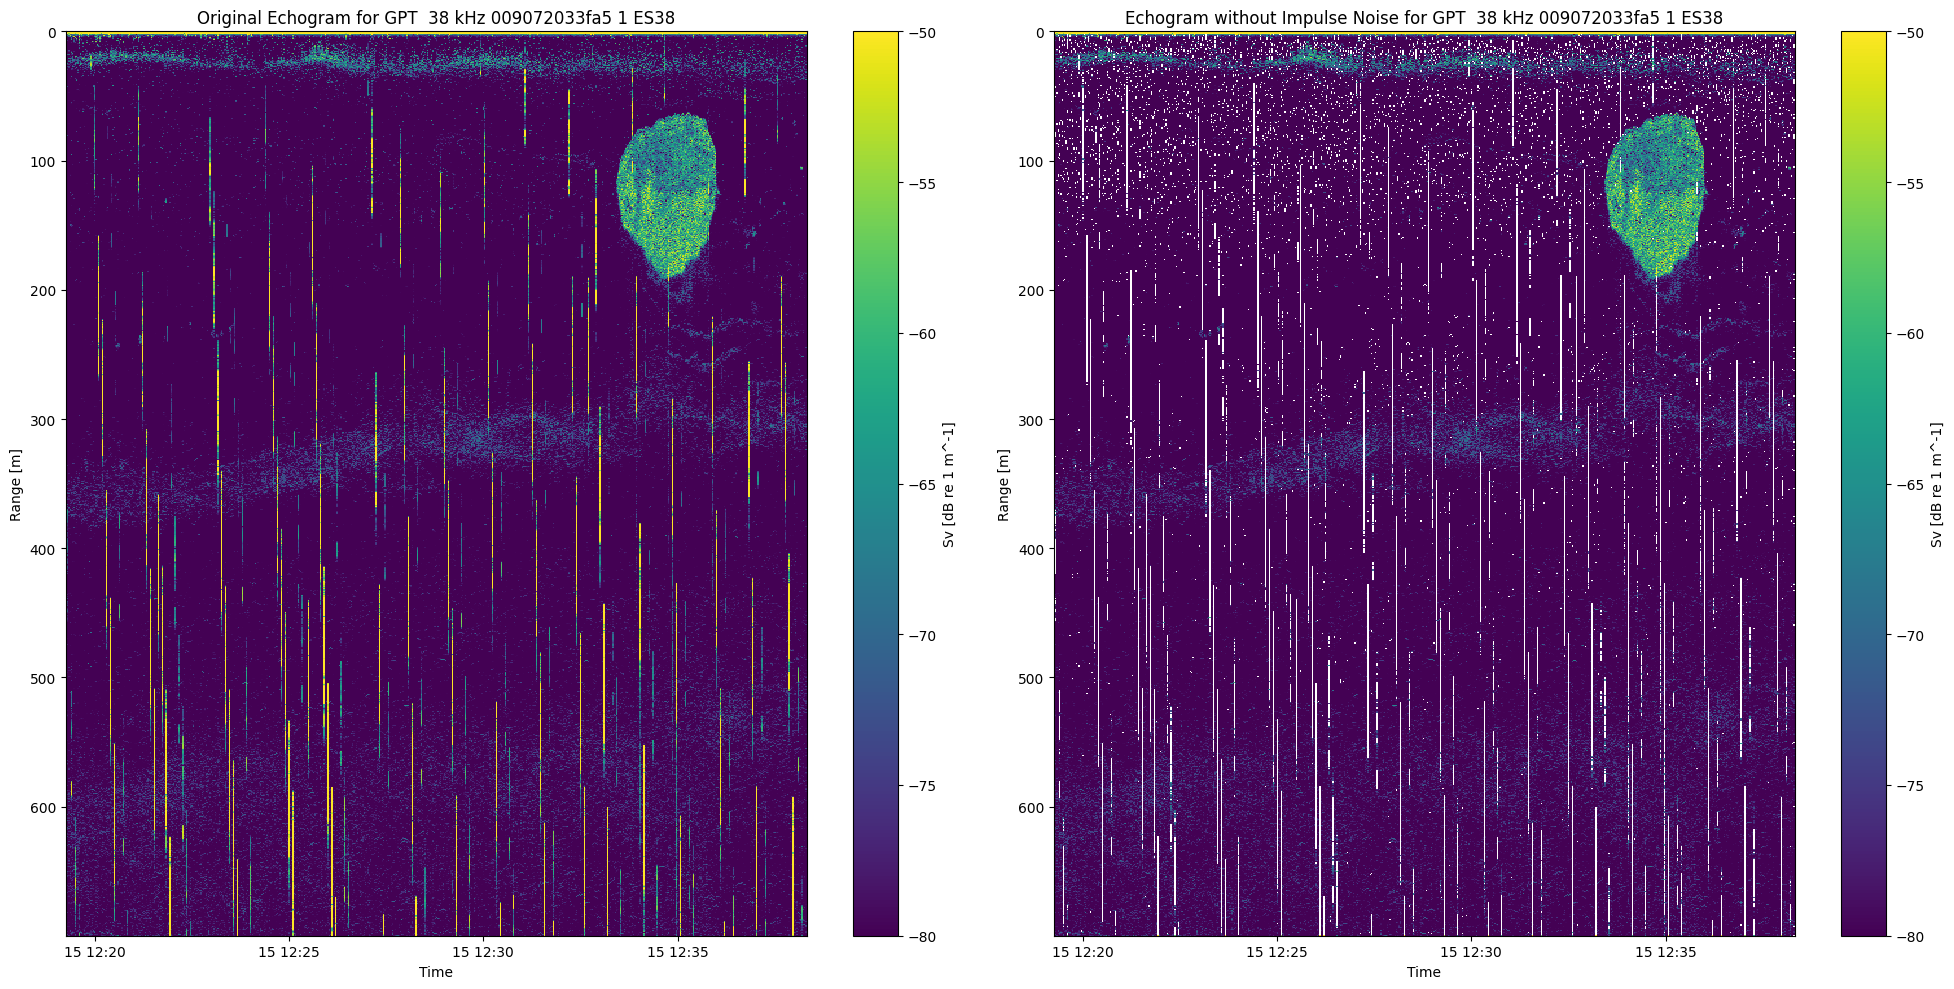

In [27]:
# Select the data from the desired channel
Sv_ds = source_Sv

# Echogram for source_Sv
Sv = Sv_ds['Sv'].sel(channel=desired_channel)
ping_time = Sv_ds['ping_time']
range_sample = Sv_ds['echo_range'].sel(channel=desired_channel)

# Create a single figure for both echograms
plt.figure(figsize=(20, 10)) 

# Create the first echogram (original Sv)
plt.subplot(1, 2, 1)
plt.pcolormesh(ping_time, range_sample.T, Sv.T, cmap='viridis', vmin=-80, vmax=-50)
plt.gca().invert_yaxis()
plt.colorbar(label='Sv [dB re 1 m^-1]')
plt.ylabel('Range [m]')
plt.xlabel('Time')
plt.title(f'Original Echogram for {desired_channel}')

# Echogram for Sv_in (after applying mask)
Sv = Sv_in['Sv'].sel(channel=desired_channel)
ping_time = Sv_in['ping_time']
range_sample = Sv_in['echo_range'].sel(channel=desired_channel)

# Create the second echogram (Sv without impulse noise)
plt.subplot(1, 2, 2)
plt.pcolormesh(ping_time, range_sample.T, Sv.T, cmap='viridis', vmin=-80, vmax=-50)
plt.gca().invert_yaxis()
plt.colorbar(label='Sv [dB re 1 m^-1]')
plt.ylabel('Range [m]')
plt.xlabel('Time')
plt.title(f'Echogram without Impulse Noise for {desired_channel}')

plt.tight_layout()
plt.show()

**Compute NASC**

In [28]:
Sv = Sv_in['Sv'].sel(channel=desired_channel).values  # Extract numpy array from xarray.DataArray
ping_time = Sv_in['ping_time'].values
echo_range = Sv_in['echo_range'].sel(channel=desired_channel).values[1,:] 

Sv38inoff = Sv
r38 = echo_range
t38 = ping_time

NASC, NASCper = Sv2NASC(Sv38inoff.T, r38, 20, 250, operation='sum')

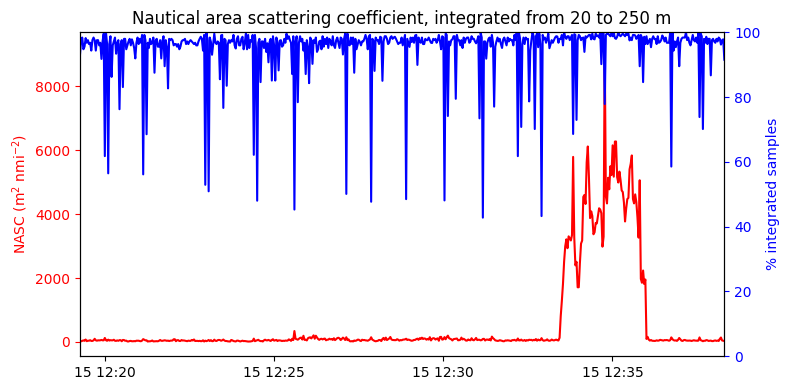

In [29]:
# Create a figure and subplot.
fig, ax1 = plt.subplots(figsize=(8,4))

# Plot NASC on the primary y-axis.
ax1.plot(t38, NASC, '-r')
ax1.set_xlim(t38[0], t38[-1])
ax1.tick_params(axis='y', colors='r')
ax1.set_ylabel('NASC (m$^2$ nmi$^{-2}$)', color='r')

# Create a twin y-axis for NASCper.
ax2 = ax1.twinx()
ax2.plot(t38, NASCper, '-b')
ax2.set_xlim(t38[0], t38[-1])
ax2.set_ylim(0, 100)
ax2.tick_params(axis='y', colors='b')
ax2.set_ylabel('% integrated samples', color='b')

# Set the title.
ax2.set_title('Nautical area scattering coefficient, integrated from 20 to 250 m')

# Adjust layout and display the plot.
plt.tight_layout()
plt.show()


---------

-------

**Provide find_Sv2NASC_for_all_channels() function to make Sv2NASC() compatible with echopype (for all channels)**
- This function was written to integrate the Sv2NASC() function from echopy so it operates in the echopype style.

In [30]:
def find_Sv2NASC_for_all_channels(Sv_ds: xr.Dataset, r0: float, r1: float, operation='mean') -> xr.Dataset:
    
    """
    Calculate the Nautical Area Scattering Coefficient (NASC) and the percentage of samples integrated (NASC_per) 
    for each channel within the provided Sv_ds dataset. 
    The calculation is performed for a given range interval.

    Parameters
    ----------
    Sv_ds : xr.Dataset
        The dataset containing Sv data. It must have the `channel` and `ping_time` coordinates 
        and relevant data variables: `Sv` and `echo_range`.
    r0 : float
        The top range limit (in meters) for the depth integration.
    r1 : float
        The bottom range limit (in meters) for the depth integration.
    operation : str, optional
        The method of calculating NASC. Accepts either "mean" or "sum". Defaults to "mean".

    Returns
    -------
    xr.Dataset
        The input dataset augmented with two new data variables: 'Sv2NASC' and 'Sv2NASC_per'.
        Both data variables have two dimensions: 'channel' and 'ping_time'.

    """

    # Get all unique channels in the Dataset
    channels = Sv_ds['channel'].values

    all_NASC = []
    all_NASCper = []

    for channel in channels:

        Sv = Sv_ds['Sv'].sel(channel=channel).values  # Extract numpy array from xarray.DataArray
        ping_time = Sv_ds['ping_time'].values
        echo_range = Sv_ds['echo_range'].sel(channel=channel).values[1,:] 

        NASC, NASCper = Sv2NASC(Sv.T, echo_range, r0, r1, operation=operation)
        
        # Store results in lists
        all_NASC.append(NASC)
        all_NASCper.append(NASCper)

    # Convert lists to numpy arrays
    all_NASC = np.array(all_NASC)
    all_NASCper = np.array(all_NASCper)

    # Add NASC and NASC_per as new data variables to the existing Sv_ds
    Sv_ds['Sv2NASC'] = xr.DataArray(
        all_NASC,
        dims=("channel", "ping_time"),
        coords={"channel": channels, "ping_time": ping_time}
    )

    Sv_ds['Sv2NASC_per'] = xr.DataArray(
        all_NASCper,
        dims=("channel", "ping_time"),
        coords={"channel": channels, "ping_time": ping_time}
    )
    
    return Sv_ds


Sv_NASC = find_Sv2NASC_for_all_channels(Sv_in, 20, 250, operation='sum')

In [31]:
Sv_NASC

<xarray.Dataset>
Dimensions:                        (channel: 3, ping_time: 572,
                                    range_sample: 3782, filenames: 1, time3: 572)
Coordinates:
  * channel                        (channel) object 'GPT  38 kHz 009072033fa5...
  * ping_time                      (ping_time) datetime64[ns] 2009-12-15T12:1...
  * range_sample                   (range_sample) int64 0 1 2 ... 3779 3780 3781
  * filenames                      (filenames) int64 0
  * time3                          (time3) datetime64[ns] 2009-12-15T12:19:16...
Data variables: (12/18)
    Sv                             (channel, ping_time, range_sample) float64 ...
    echo_range                     (channel, ping_time, range_sample) float64 ...
    frequency_nominal              (channel) float64 3.8e+04 1.2e+05 2e+05
    sound_speed                    (channel, ping_time) float64 1.446e+03 ......
    sound_absorption               (channel, ping_time) float64 0.00972 ... 0...
    sa_correction                  (ping_time, channel) float64 -0.63 ... -0.31
    ...                             ...
    beamwidth_alongship            (channel, ping_time) float64 7.0 7.0 ... 6.44
    beamwidth_athwartship          (channel, ping_time) float64 7.1 7.1 ... 6.43
    source_filenames               (filenames) <U118 '/Users/simedroniraluca/...
    water_level                    (channel, time3) float64 0.0 0.0 ... 0.0 0.0
    Sv2NASC                        (channel, ping_time) float64 17.71 ... 5.7...
    Sv2NASC_per                    (channel, ping_time) float64 93.16 ... 91.55
Attributes:
    processing_software_name:     echopype
    processing_software_version:  0.1.dev2285+g595ff46
    processing_time:              2023-08-25T08:55:58Z
    processing_function:          calibrate.compute_Sv
    mask_software_name:           echopype
    mask_software_version:        0.1.dev2285+g595ff46
    mask_time:                    2023-08-25T08:55:58Z
    mask_function:                mask.apply_mask

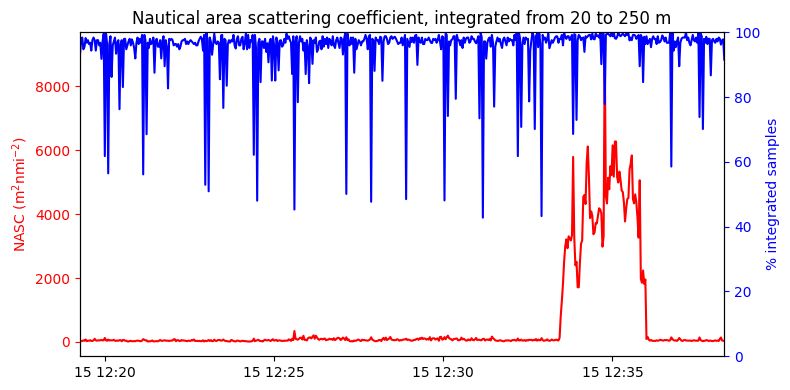

In [32]:
t38 = Sv_NASC['ping_time'].values
NASC =   Sv_NASC['Sv2NASC'].sel(channel=desired_channel).values  
NASCper =  Sv_NASC['Sv2NASC_per'].sel(channel=desired_channel).values  

# Create a figure and subplot.
fig, ax1 = plt.subplots(figsize=(8,4))

# Plot NASC on the primary y-axis.
ax1.plot(t38, NASC, '-r')
ax1.set_xlim(t38[0], t38[-1])
ax1.tick_params(axis='y', colors='r')
ax1.set_ylabel('NASC (m$^2$nmi$^{-2}$)', color='r')

# Create a twin y-axis for NASCper.
ax2 = ax1.twinx()
ax2.plot(t38, NASCper, '-b')
ax2.set_xlim(t38[0], t38[-1])
ax2.set_ylim(0, 100)
ax2.tick_params(axis='y', colors='b')
ax2.set_ylabel('% integrated samples', color='b')

# Set the title.
ax2.set_title('Nautical area scattering coefficient, integrated from 20 to 250 m')

# Adjust layout and display the plot.
plt.tight_layout()
plt.show()

**The output of the function find_Sv2NASC_for_all_channels() is the same as the one provided by the echopy tests, which can be found [HERE](https://github.com/open-ocean-sounding/echopy/blob/master/tests/compute_area_scattering.png).**